<a href="https://colab.research.google.com/github/LordLean/Acquired-Intelligence-Adaptive-Behaviour/blob/master/CV_Labs/CV_183708.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some non-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 3.4.2.17
    Unins

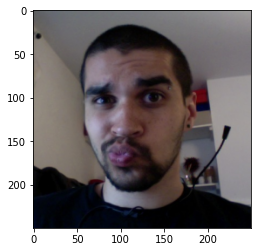

In [61]:
from google.colab import files
uploaded = files.upload()

# Picture of Me.
full_path = "/content/" + "alex.jpg"
alex = cv2.imread(full_path)
alex = alex[:,150:550,:]
alex = cv2.resize(alex, (250,250), interpolation = cv2.INTER_AREA)
alex = cv2.cvtColor(alex,cv2.COLOR_BGR2RGB)
plt.imshow(alex)

In [7]:
#@title Load Data
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.
#!wget "https://sussex.box.com/shared/static/2nansy5fdps2dcycsqb7r06cddbbkskd.npz" -O training_images.npz
!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz

--2020-05-24 20:41:13--  http://users.sussex.ac.uk/~is321/training_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375302693 (358M)
Saving to: ‘training_images.npz’

training_images.npz 100%[===================>] 357.92M  25.5MB/s    in 18s     

2020-05-24 20:41:31 (20.0 MB/s) - ‘training_images.npz’ saved [375302693/375302693]

--2020-05-24 20:41:32--  http://users.sussex.ac.uk/~is321/test_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74915629 (71M)
Saving to: ‘test_images.npz’

test_images.npz     100%[===================>]  71.44M  16.9MB/s    in 6.4s    

2020-05-24 20:41:39 (11.1 MB/s) - ‘test_images.npz’ saved [74915629/74915629]

--2020

In [0]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
#@title Load seperate files

# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)
test_data = np.load("test_images.npz", allow_pickle=True)
examples_data = np.load("examples.npz", allow_pickle=True)

# Extract the images - Train.
train_images = data['images']
# and the data points. - iBUG 300-W
train_pts = data['points']
# Print data shape.
print("Image Data Shape: {}, Points Data Shape: {}".format(train_images.shape,train_pts.shape))


# Extract the images - Test.
test_images = test_data['images']
# Print data shape.
print("Test Data Shape: {}".format(test_images.shape))


# Extract the images - Examples.
example_images = examples_data['images']
# Print data shape.
print("Example Data Shape: {}".format(example_images.shape))

Image Data Shape: (2811, 250, 250, 3), Points Data Shape: (2811, 68, 2)
Test Data Shape: (554, 250, 250, 3)
Example Data Shape: (6, 250, 250, 3)


In [0]:
#@title Function - Visualize Images and Points
def visualise_pts(img, pts, title_num):
  titles = ["Ground Truth Points", "Predictions"]
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.title(titles[title_num])
  plt.show()

In [0]:
#@title Function - Calculating Prediction Error and exporting results
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


# np.mean(euclid_dist(predictions[0].reshape(68,2),train_pts[2311]))

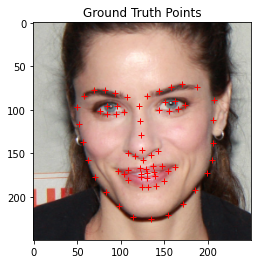

In [5]:
for i in range(1):
  idx = np.random.randint(0, train_images.shape[0])
  visualise_pts(train_images[i, ...], train_pts[i, ...],title_num=0)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Norm X
norm_train_images = train_images/255 # astype("float32")?
# Norm y
y = train_pts/250
y = np.reshape(y,(-1,136))


# Train Test split
X_train = norm_train_images[:-500]
X_test = norm_train_images[:500]

# Train Test split
y_train = y[:-500]
y_test = y[:500]

<br>

In [71]:

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(68*2))

model.add(Dense(68*2))
model.add(Activation("sigmoid"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mse"])

model.fit(X_train,y_train, epochs=2, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/2
73/73 [==============================] - 185s 3s/step - loss: 0.1314 - mse: 0.1314 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 2/2
73/73 [==============================] - 178s 2s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0018 - val_mse: 0.0018


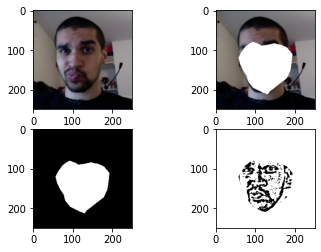

In [90]:
alex_copy = alex.copy() /255

X_test_copy = X_test.copy()
X_test_copy.shape
X_test_copy[-1] = alex_copy

alex_predictions = model.predict(X_test_copy) * 250

alex_pts = alex_predictions[-1].reshape(68,2)

visualise_pts(alex, alex_pts,1)

p1 = alex_pts[0].reshape(1,-1)
p2 = alex_pts[17:27]
p3 = alex_pts[16::-1]
tester = np.concatenate((p1,p2,p3))

img = alex.copy()

img = cv2.fillPoly(img, np.array([tester], dtype=np.int32), color=(255,255,255))
# img = cv2.fillPoly(img, np.array([tester,tester], dtype=np.int32), color=(255,255,255))

# cut_img stores array where elements equal 255 or then 0.
cut_img = img.copy()
cut_img[cut_img<255] = 0

# plt.imshow(alex)
# plt.show()
# plt.imshow(img)
# plt.show()
# plt.imshow(cut_img)
# plt.show()

# Coordinates where value is greater than 0. I.e. all pixels
# within the facebounds.
segmented_coordinates = np.column_stack(np.where(cut_img > 0))


# Final Image
mask = cut_img
mask_inv = cv2.bitwise_not(mask)
tester = alex.copy()
img_gray = np.mean(tester, axis=2).astype('uint8')
binary2 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(binary2, cmap="gray")

mask_inv = cv2.bitwise_not(mask)
binary3 = np.mean(mask_inv,axis=2).astype("uint8")

dst = cv2.add(binary2,binary3)
# img1[0:rows, 0:cols ] = dst
# plt.imshow(dst, cmap="gray")


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(alex)
axarr[0,1].imshow(img)
axarr[1,0].imshow(cut_img)
axarr[1,1].imshow(dst, cmap="gray")

In [7]:
# Euc dist: 12.053532803980405
model_layers = [
                
    tf.keras.layers.Conv2D( 256 , input_shape=X_train.shape[1:] , kernel_size=( 3 , 3 ) , strides=2 , activation='relu' ),
    tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=2 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    # tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 68*2 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 68*2 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 68*2 , kernel_size=( 3 , 3 ) , strides=1 , activation="sigmoid"),

]
model = tf.keras.Sequential( model_layers )
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(68*2))

model.add(Dense(68*2))
model.add(Activation("sigmoid"))
model.compile( loss=tf.keras.losses.mean_squared_error , optimizer=tf.keras.optimizers.Adam( lr=0.0001 ) , metrics=[ 'mse' ] )

model.fit(X_train,y_train, epochs=2, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/2
73/73 [==============================] - 2192s 30s/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2/2
73/73 [==============================] - 2191s 30s/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018


In [0]:
model.summary()

In [0]:
predictions = model.predict(X_test) * 250

In [0]:
npArray = np.array([[[0, 162, 232, 255]]], dtype='uint8')
for i in range(2):
    visualise_pts(npArray, train_pts[2311+i, ...],0)
    visualise_pts(npArray,  predictions[i, ...].reshape(68,2),1)

In [0]:
for i in range(10,12):
    visualise_pts(train_images[2311+i, ...], train_pts[2311+i, ...],0)
    visualise_pts(train_images[2311+i, ...],  predictions[i, ...].reshape(68,2),1)

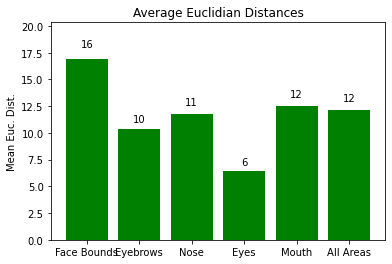

Mean Euclidian Distance All Images and Points: 12.134652147138379


In [12]:
#@title Plot average Euclidian Distance.
# across various slices of the 68 points.

euclid_total_list = list()
euclid_facebounds_list = list()
euclid_eyebrows_list = list()
euclid_nose_list = list()
euclid_eyes_list = list()
euclid_mouth_list = list()

for i in range(500):
  # Calculate Euclidian Distance values for each Image.
  euclid_totals = euclid_dist(predictions[i].reshape(68,2),train_pts[2311+i])
  euclid_total_list.append(euclid_totals)
  # Mean Euc. Dist. across face outline.
  euclid_facebounds_list.append(np.mean(euclid_totals[0:17]))
  # Mean Euc. Dist. across eyebrows.
  euclid_eyebrows_list.append(np.mean(euclid_totals[18:27]))
  # Mean Euc. Dist. across nose.
  euclid_nose_list.append(np.mean(euclid_totals[28:36]))
  # Mean Euc. Dist. across eyes.
  euclid_eyes_list.append(np.mean(euclid_totals[37:48]))
  # Mean Euc. Dist. across mouth.
  euclid_mouth_list.append(np.mean(euclid_totals[49:68]))

euclid_total_vals = np.mean(euclid_total_list)
euclid_facebounds_total = np.mean(euclid_facebounds_list)
euclid_eyebrows_total = np.mean(euclid_eyebrows_list)
euclid_nose_total = np.mean(euclid_nose_list)
euclid_eyes_total = np.mean(euclid_eyes_list)
euclid_mouth_total = np.mean(euclid_mouth_list)



facial_areas = ["Face Bounds", "Eyebrows", "Nose", "Eyes", "Mouth", "All Areas"]
# Avg areas for bar plot.
facial_area_vals = [euclid_facebounds_total, euclid_eyebrows_total,
                    euclid_nose_total, euclid_eyes_total,
                    euclid_mouth_total, euclid_total_vals]

fig, ax = plt.subplots()
ax.set_ylabel("Mean Euc. Dist.")
rects1 = ax.bar(facial_areas,facial_area_vals, color="g")
def autolabel(rects):
# http://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height
    Slightly Modded
    """
    height_list = []
    for rect in rects:
        height = rect.get_height()
        height_list.append(height)
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    return max(height_list)

# Force y_lim to have space for all values incase some do not appear.
max_height = autolabel(rects1)
ax.set_ylim(0,max_height+max_height/5)
# Plot
plt.title("Average Euclidian Distances")
plt.show()
# Print total avg. distance.
print("Mean Euclidian Distance All Images and Points: {}".format(euclid_total_vals))

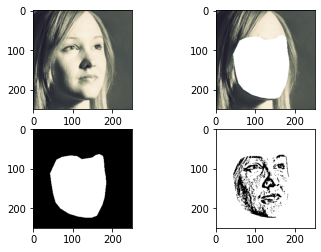

In [8]:
#@title Face Segmentation
img_num = 200
p1 = train_pts[img_num][0].reshape(1,-1)
p2 = train_pts[img_num][17:27]
p3 = train_pts[img_num][16::-1]
tester = np.concatenate((p1,p2,p3))

img = train_images[img_num].copy()

img = cv2.fillPoly(img, np.array([tester], dtype=np.int32), color=(255,255,255))
# img = cv2.fillPoly(img, np.array([tester,tester], dtype=np.int32), color=(255,255,255))

# cut_img stores array where elements equal 255 or then 0.
cut_img = img.copy()
cut_img[cut_img<255] = 0

# plt.imshow(train_images[img_num])
# plt.show()
# plt.imshow(img)
# plt.show()
# plt.imshow(cut_img)
# plt.show()

# Coordinates where value is greater than 0. I.e. all pixels
# within the facebounds.
segmented_coordinates = np.column_stack(np.where(cut_img > 0))


# Final Image
mask = cut_img
mask_inv = cv2.bitwise_not(mask)
tester = train_images[img_num].copy()
img_gray = np.mean(tester, axis=2).astype('uint8')
binary2 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(binary2, cmap="gray")

mask_inv = cv2.bitwise_not(mask)
binary3 = np.mean(mask_inv,axis=2).astype("uint8")

dst = cv2.add(binary2,binary3)
# img1[0:rows, 0:cols ] = dst
# plt.imshow(dst, cmap="gray")


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(train_images[img_num])
axarr[0,1].imshow(img)
axarr[1,0].imshow(cut_img)
axarr[1,1].imshow(dst, cmap="gray")

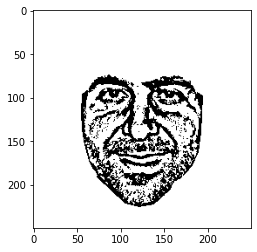

In [99]:
tester = train_images[3].copy()
img_gray = np.mean(tester, axis=2).astype('uint8')
binary2 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(binary2, cmap="gray")

mask_inv = cv2.bitwise_not(mask)
binary3 = np.mean(mask_inv,axis=2).astype("uint8")

dst = cv2.add(binary2,binary3)
# img1[0:rows, 0:cols ] = dst
plt.imshow(dst, cmap="gray")

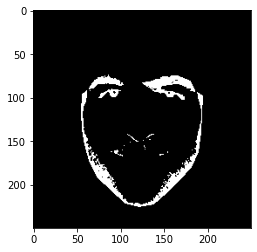

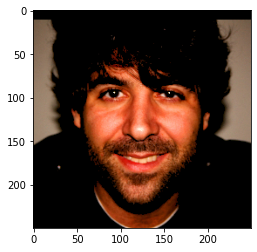

In [77]:
img2 = train_images[img_num].copy()
img1 = cut_img.copy()
# I want to put logo on top-left corner, So I create a ROI
rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols ]
# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
# Put logo in ROI and modify the main image
dst = cv2.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst
plt.imshow(img1)

plt.imshow(img1_bg)
plt.show()
plt.imshow(img2_fg)
plt.show()

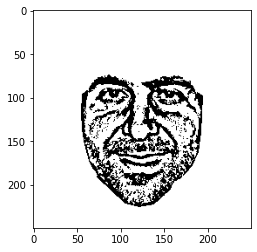

In [98]:
tester = train_images[3].copy()
img_gray = np.mean(tester, axis=2).astype('uint8')
binary2 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(binary2, cmap="gray")

mask_inv = cv2.bitwise_not(mask)
binary3 = np.mean(mask_inv,axis=2).astype("uint8")

dst = cv2.add(binary2,binary3)
# img1[0:rows, 0:cols ] = dst
plt.imshow(dst, cmap="gray")

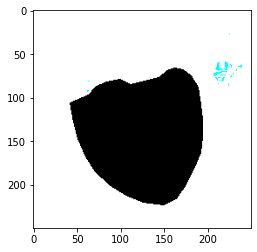

NameError: ignored

In [15]:
mask = cut_img
mask_inv = cv2.bitwise_not(mask)
plt.imshow(mask_inv)
plt.show()
dst = cv2.add(mask_inv,img2_fg)
img1[0:rows, 0:cols ] = dst
plt.imshow(img1)


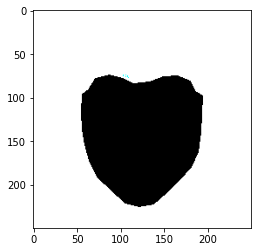

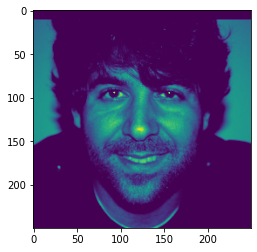

error: ignored

In [67]:
mask = cut_img
mask_inv = cv2.bitwise_not(mask)
plt.imshow(mask_inv)
plt.show()

og_img = train_images[img_num].copy()
gray = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

rows, cols, channels = og_img.shape
og_img = og_img[0:rows, 0:cols]

# Bitwise-OR mask and original image
mask = mask.astype(np.int8)
colored_portion = cv2.bitwise_or(og_img, og_img, mask = mask)
colored_portion = colored_portion[0:rows, 0:cols]

# Bitwise-OR inverse mask and grayscale image
gray_portion = cv2.bitwise_or(gray, gray, mask = mask_inv)
gray_portion = np.stack((gray_portion,)*3, axis=-1)

# Combine the two images
output = colored_portion + gray_portion

In [0]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


examples.npz  results.csv  sample_data	test_images.npz  training_images.npz


# Basic Regression Pipeline
Take a look at the FML lab on [linear regression](https://colab.research.google.com/drive/1P3gvarGJmrqatZ9ielZnT8_5yRoTHJ-b) to see a simple method for predicting real valued numbers.

<br>

In [0]:
#@title Model_ONE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Norm X
norm_train_images = train_images/255
# Train Test split
X_train = norm_train_images[:-500]
X_test = norm_train_images[:500]

# Norm y
y = train_pts/250
y = np.reshape(y,(-1,136))
# Train Test split
y_train = y[:-500]
y_test = y[:500]



model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(68*2))

model.add(Dense(68*2))
model.add(Activation("sigmoid"))

model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mse"])

model.fit(X_train,y_train, epochs=2, batch_size=32, validation_data=(X_test,y_test))


predictions = model.predict(X_test) * 250


npArray = np.array([[[0, 162, 232, 255]]], dtype='uint8')
for i in range(2):
    visualise_pts(npArray, train_pts[2311+i, ...],0)
    visualise_pts(npArray,  predictions[i, ...].reshape(68,2),1)


for i in range(2):
    visualise_pts(train_images[2311+i, ...], train_pts[2311+i, ...],0)
    visualise_pts(train_images[2311+i, ...],  predictions[i, ...].reshape(68,2),1)


# 14.9941595471739
euc_mean = np.zeros((1,500)).flatten()
for i in range(500):
  avg = np.mean(euclid_dist(predictions[i].reshape(68,2),train_pts[2311+i]))
  euc_mean[i] = avg
np.mean(euc_mean)